<a href="https://colab.research.google.com/github/Harshkotkar/Deep-Learning/blob/main/APTOS_Eye_Preprocessing_in_Diabetic_Retinopathy(full_and_final_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# # IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# # RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

aptos2019_blindness_detection_path = kagglehub.competition_download('aptos2019-blindness-detection')

print('Data source import complete.')


100%|██████████| 9.51G/9.51G [00:54<00:00, 189MB/s]

Extracting files...


Data source import complete.


In [3]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models


In [5]:
import os

print(aptos2019_blindness_detection_path)  # This shows the base folder
print(os.listdir(aptos2019_blindness_detection_path))  # List what’s inside


/root/.cache/kagglehub/competitions/aptos2019-blindness-detection
['train_images', 'train.csv', 'test.csv', 'test_images', 'sample_submission.csv']


In [6]:
import os
import pandas as pd

# Base dataset path
base_path = "/root/.cache/kagglehub/competitions/aptos2019-blindness-detection"

# Load CSVs
train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
test_df = pd.read_csv(os.path.join(base_path, "test.csv"))

print(train_df.head())
print(test_df.head())


        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
        id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4


In [7]:
train_images_path = os.path.join(base_path, "train_images")
test_images_path  = os.path.join(base_path, "test_images")


###Why tf.data? Efficient handling of large image datasets → parallelism + prefetching.

Why resize to (224×224)? Most pretrained CNN backbones (ResNet, EfficientNet, Inception) expect 224×224 inputs. Keeping consistency allows us to later plug in pretrained models easily.

Why normalize (0–1)? Neural nets converge faster when input values are small and consistent. Images originally have pixel values 0–255; dividing by 255 standardizes them. New section

In [8]:
import tensorflow as tf
import os

train_imgs = "/root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images"

IMG_SIZE = 224
BATCH_SIZE = 32

def load_image(img_id, label):
    # Create image path using tf.strings.join
    img_path = tf.strings.join([train_imgs, "/", img_id, ".png"])

    # Read image file
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0  # normalize

    return img, label

# Convert dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df['id_code'].values,
                                               train_df['diagnosis'].values))
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Train Test Split

##why do we not do the X_train ,Y_train, that one split?
### Our Case (APTOS Dataset)

Our dataframe looks like this:

id_code         	diagnosis
000c1434d8d7	       2
001639a390f0	       4
0024cdab0c1e	       1
id_code → not really a feature, it’s just the filename of the image.

diagnosis → the label (0–4).


##In this dataset, the dataframe doesn’t directly contain the features (images).

##Instead, it maps id_code (filename) → diagnosis (label).

##We split the dataframe rows while keeping both columns, then later load the actual images using those filenames.

###Why stratify?
Because the dataset is imbalanced (some disease classes are rarer). stratify ensures both train and validation have similar class distributions.

Training samples: 2343
Validation samples: 586


array([[<Axes: title={'center': 'diagnosis'}>]], dtype=object)

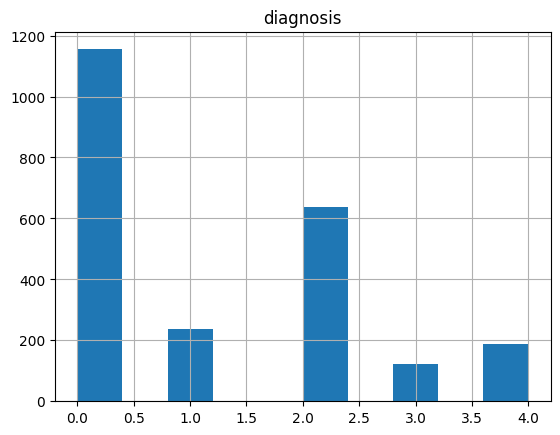

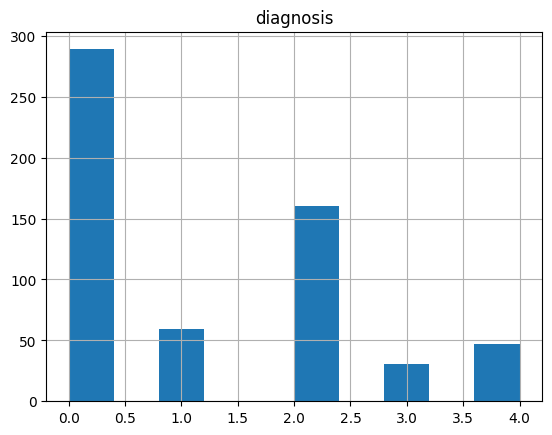

In [10]:
from sklearn.model_selection import train_test_split

# Train-validation split
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
train_df.hist()
val_df.hist()

In [11]:
!ls /root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images | head -20


000c1434d8d7.png
001639a390f0.png
0024cdab0c1e.png
002c21358ce6.png
005b95c28852.png
0083ee8054ee.png
0097f532ac9f.png
00a8624548a9.png
00b74780d31d.png
00cb6555d108.png
00cc2b75cddd.png
00e4ddff966a.png
00f6c1be5a33.png
0104b032c141.png
0124dffecf29.png
0125fbd2e791.png
012a242ac6ff.png
014508ccb9cb.png
0151781fe50b.png
0161338f53cc.png


In [11]:
# train_imgs = "/root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images"

# # Fix filenames to match actual files
# train_df["id_code"] = train_df["id_code"].astype(str) + ".png"
# test_df["id_code"]  = test_df["id_code"].astype(str) + ".png"

# # ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory="/root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images",
#     x_col="id_code",
#     y_col="diagnosis",
#     subset="training",
#     batch_size=32,
#     seed=42,
#     shuffle=True,
#     class_mode="categorical",
#     target_size=(224, 224))

# valid_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory="/root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images",
#     x_col="id_code",
#     y_col="diagnosis",
#     subset="validation",
#     batch_size=32,
#     seed=42,
#     shuffle=True,
#     class_mode="categorical",
#     target_size=(224, 224))



In [22]:
train_df["id_code"] = train_df["id_code"].str.replace(r"(\.png)+$", ".png", regex=True)
test_df["id_code"]  = test_df["id_code"].str.replace(r"(\.png)+$", ".png", regex=True)

# train_df["id_code"] = train_df["id_code"].str.replace(r"(\.png)+$", ".png", regex=True)
# test_df["id_code"]  = test_df["id_code"].str.replace(r"(\.png)+$", ".png", regex=True)

# Train-validation split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)

# Define dataset loader
def load_image(img_id, label):
    img_path = tf.strings.join([train_imgs, "/", img_id])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df["id_code"].values, train_df["diagnosis"].values))
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df["id_code"].values, val_df["diagnosis"].values))
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [23]:
import os

train_imgs = "/root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images"
files = os.listdir(train_imgs)
print("Total files in train_images:", len(files))
print("First 10 files:", files[:10])


Total files in train_images: 3662
First 10 files: ['a3b2e93d058b.png', '936299166bea.png', '5b3d41626ec5.png', '172df1330a60.png', '25d069089c5e.png', '504a69096fcb.png', 'cd5714db652d.png', 'cd1c98ec48b1.png', '7f1f3269f546.png', 'a30a143a53a3.png']


In [24]:
# Check if all image names exist in train_images folder
missing_files = [f for f in train_df["id_code"].values if f not in files]
print("Missing files:", len(missing_files))
print(missing_files[:10])


Missing files: 1199
['a8582e346df0', '0dce95217626', '842d697884f6', '6dc0281f11e3', '1116271db4ea', 'f0e1201b5c1f', 'ef26625121b3', '9eaf735cf01f', '16ce555748d8', '9e99ae6ee7af']


In [16]:
from tensorflow.keras import layers, models

# Simple CNN Model

model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(5, activation='softmax')
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
#conv2d_4
#Kh=kernal heingt,Kw=kernal width, Cin=chanel input as rgb it  is 3 and grayscal is 1
#(Kh x Kw x Cin x Cout )+Cout
#(3×3×32×64)+64=(18,432)+64=18,496

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history=model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=10,
                  verbose=1)

Epoch 1/10


NotFoundError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) NOT_FOUND:  Error in user-defined function passed to ParallelMapDatasetV2:15 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: /root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images/9a326446c431; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) NOT_FOUND:  Error in user-defined function passed to ParallelMapDatasetV2:15 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: /root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images/9a326446c431; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_2156]

##verbose determines how much information the computer displays during the process.
verbose=0 means no output. The computer will not show any progress until the process is complete.
verbose=1 means a progress bar is shown. The computer displays a bar that updates as the training progresses, along with a summary at the end of each pass through the data (epoch).
verbose=2 means only the summary is shown. The computer only prints a line with the results at the end of each epoch

In [18]:
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


NotFoundError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) NOT_FOUND:  /root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images/191348830ddf; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) NOT_FOUND:  /root/.cache/kagglehub/competitions/aptos2019-blindness-detection/train_images/191348830ddf; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_2279]

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:   # loop through batches
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())   # no argmax, already integers

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Quadratic Weighted Kappa
kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print("Quadratic Weighted Kappa:", kappa)


In [25]:
base_path = "/root/.cache/kagglehub/competitions/aptos2019-blindness-detection"
train_imgs = os.path.join(base_path, "train_images")

In [26]:
train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
test_df = pd.read_csv(os.path.join(base_path, "test.csv"))

In [27]:
train_df["id_code"] = train_df["id_code"].str.replace(r"(\.png)+$", ".png", regex=True)
test_df["id_code"]  = test_df["id_code"].str.replace(r"(\.png)+$", ".png", regex=True)


In [28]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)


In [29]:
# Dataset loader
IMG_SIZE = 224
BATCH_SIZE = 32

def load_image(img_id, label):
    img_path = tf.strings.join([train_imgs, "/", img_id])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label
